# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

## Import libraries and file with settings

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import os, sys

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.1-beta
geopandas version: 0.7.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
matplotlib version: 3.2.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file)

['../data/run_setting.cfg']

In [6]:
#out_dir
out_dir = config.get('general','output_dir')
if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir) + os.linesep)

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT



# Applying functions

In [7]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



In [8]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2005

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

In [9]:
def conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir, saving_plots=False, showing_plots=False):
    """Determins per year the number of fatalities per country and derivates a boolean value whether conflict has occured in one year in one country or not.

    Arguments:
        conflict_gdf {geodataframe}: geodataframe containing final selection of georeferenced conflicts
        extent_gdf {geodataframe}: geodataframe containing country polygons of selected extent
        config {configuration}: parsed configuration settings

    Keyword Arguments:
        plotting {bool}: whether or not to make annual plots of boolean conflict and conflict fatalities (default: False)
    """  
        
    print('determining whether a conflict took place or not...')
    
    # select the entries which occured in this year
    temp_sel_year = conflict_gdf.loc[conflict_gdf.year == sim_year]
    
    # merge this selection with the continent data
    data_merged = gpd.sjoin(temp_sel_year, extent_gdf, how="inner", op='within')
    
    # per country the annual total fatalities are computed and stored in a separate column
    annual_fatalities_sum = pd.merge(extent_gdf,
                                        data_merged['best'].groupby(data_merged['watprovID']).sum().\
                                        to_frame().rename(columns={"best": "best_SUM"}),
                                        on='watprovID')
    
    print(data_merged['best'].groupby(data_merged['watprovID']).sum().\
                                        to_frame().rename(columns={"best": "best_SUM"}))
    
    # if the fatalities exceed 0.0, this entry is assigned a value 1, otherwise 0
    annual_fatalities_sum['conflict_bool'] = np.where(annual_fatalities_sum['best_SUM']>0.0, 1, 0)

    print('...DONE' + os.linesep)
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey=True)

    annual_fatalities_sum.plot(ax=ax1,column='conflict_bool',
                                    vmin=0,
                                    vmax=2,
                                    categorical=True,
                                    legend=True)

    temp_sel_year.plot(ax=ax1, legend=True, color='r', label='PRIO/UCDP events')

    extent_gdf.boundary.plot(ax=ax1,
                                color='0.5',
                                linestyle=':',
                                label='water province borders')

    ax1.set_xlim(extent_gdf.total_bounds[0]-1, extent_gdf.total_bounds[2]+1)
    ax1.set_ylim(extent_gdf.total_bounds[1]-1, extent_gdf.total_bounds[3]+1)
    ax1.set_title('conflict_bool ' + str(sim_year))

    ax1.legend()
    
    annual_fatalities_sum.plot(ax=ax2, 
                                column='best_SUM',
                                vmin=0,
                                vmax=1500,
                                legend=True,
                                legend_kwds={'label': "FATALITIES_SUM",
                                            'orientation': "vertical"},)

    extent_gdf.boundary.plot(ax=ax2,
                                color='0.5',
                                linestyle=':')

    ax2.set_xlim(extent_gdf.total_bounds[0]-1, extent_gdf.total_bounds[2]+1)
    ax2.set_ylim(extent_gdf.total_bounds[1]-1, extent_gdf.total_bounds[3]+1)
    ax2.set_title('aggr. fatalities ' + str(sim_year))

    fn_out = os.path.join(out_dir, 'boolean_conflict_map_' + str(sim_year) + '.png')
    
    if saving_plots:
        plt.savefig(fn_out, dpi=300)

    if not showing_plots:
        plt.close()

    return temp_sel_year, data_merged, annual_fatalities_sum

# Analysis per year

In a first step, we want to know in which countries there was conflict or not. TO that end, we first accumulate the number of fatalities per country and use this as proxy whether there was a conlfict or not (guess there is a rather strong like...).

entering year 2000

determining whether a conflict took place or not...
           best_SUM
watprovID          
40               10
42               23
46                7
47               18
51              927
101            1000
112              12
113              29
122              31
139              18
202              10
204              53
774              62
860             100
995             736
1007            637
1008            493
1011            593
1016             29
1017            902
1216          48183
1311             25
1584             14
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2001

determining whether a conflict took place or not...
           best_SUM
watprovID          
24               65
43               11
51              126
113             293
202              64
204               7
774              98
860              39
1005            647
1006           1118
1007            427
1008            434
1011            407
1016             49
1017             48
1311             23
1315            119
1317             44
...DONE

calculating zonal statistics per aggregation unit
...DONE



C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


entering year 2002

determining whether a conflict took place or not...
           best_SUM
watprovID          
43               13
113              70
202              11
204              77
206              63
774             289
860              47
1005            300
1006            300
1007            377
1008             35
1016              6
1311             25
1315            113
1584              5
...DONE

calculating zonal statistics per aggregation unit
...DONE



C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


entering year 2003

determining whether a conflict took place or not...
           best_SUM
watprovID          
47               30
51               35
81             1126
82              241
101              10
773             118
785              95
860              13
995              36
1005              5
1006             44
1018            375
1311             25
...DONE

calculating zonal statistics per aggregation unit
...DONE



C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


entering year 2004

determining whether a conflict took place or not...
           best_SUM
watprovID          
81              710
774              46
784              25
785             329
786             120
787              10
860              20
1005            157
1006            204
1007             49
1015            653
1018           1153
1020              8
1311             25
...DONE

calculating zonal statistics per aggregation unit
...DONE



C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


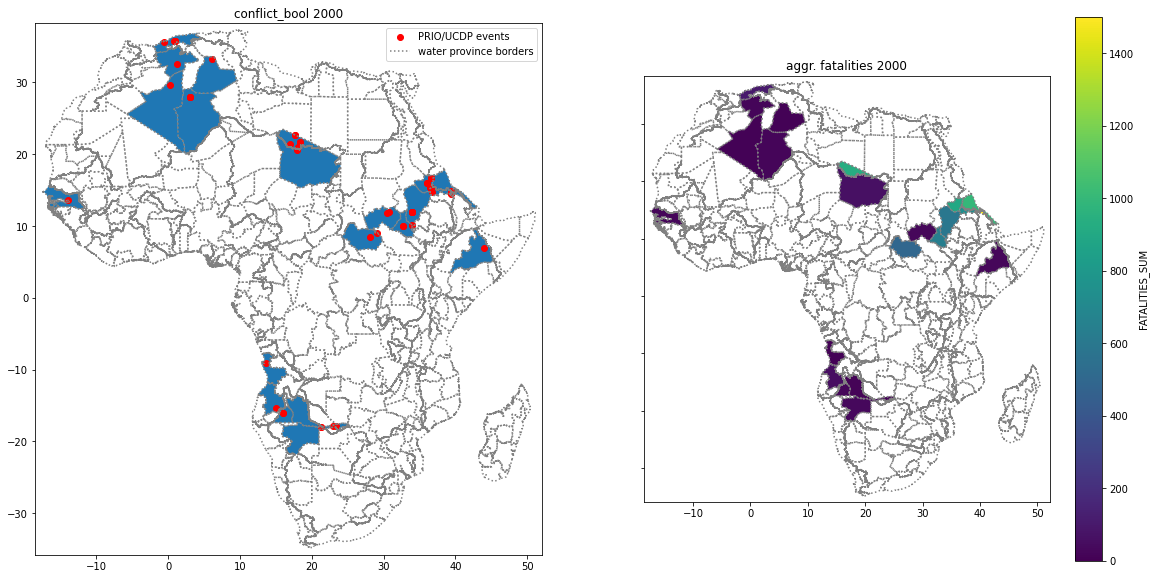

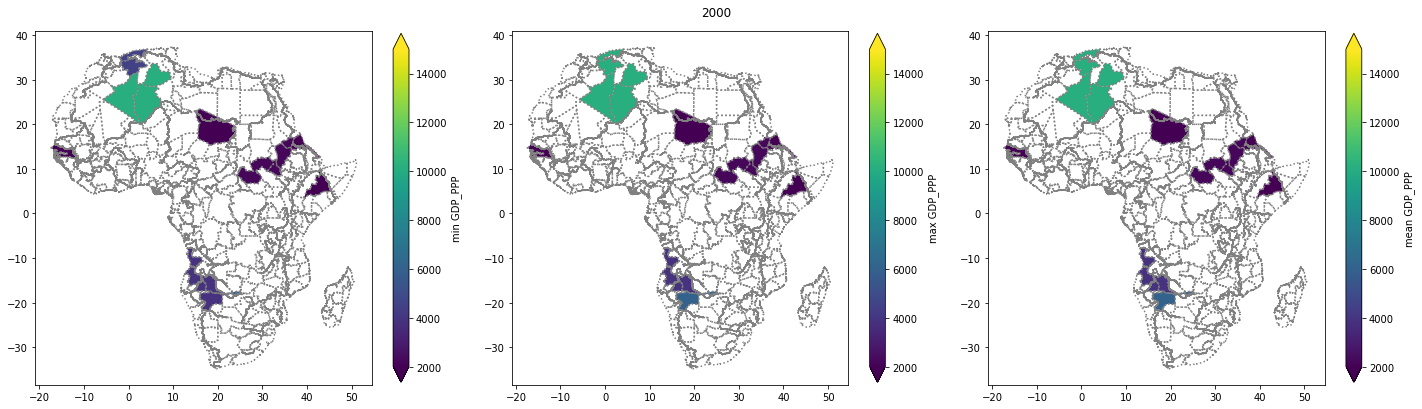

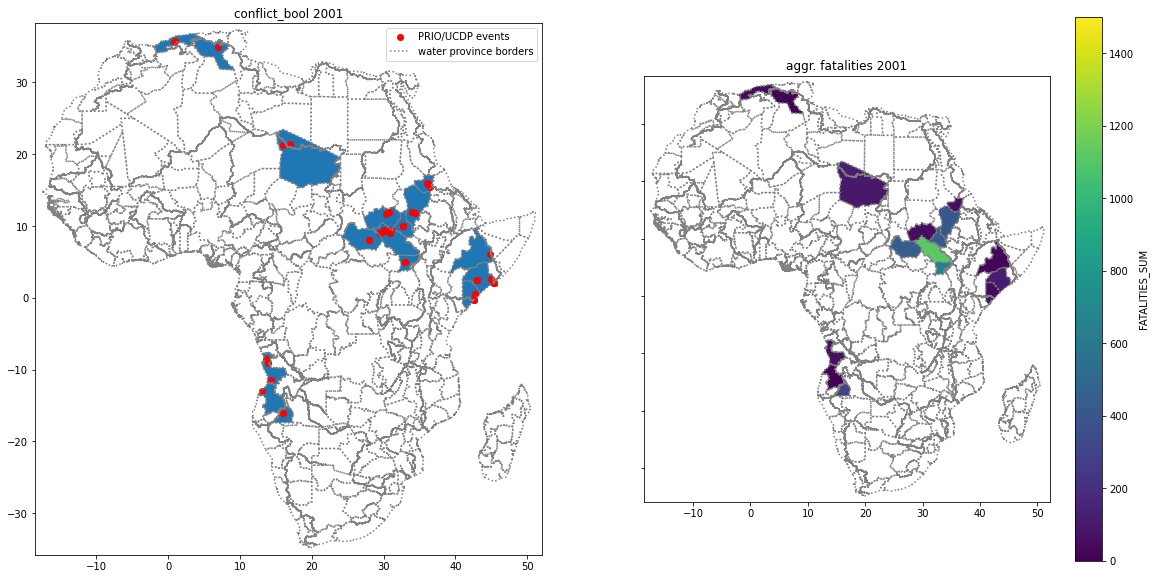

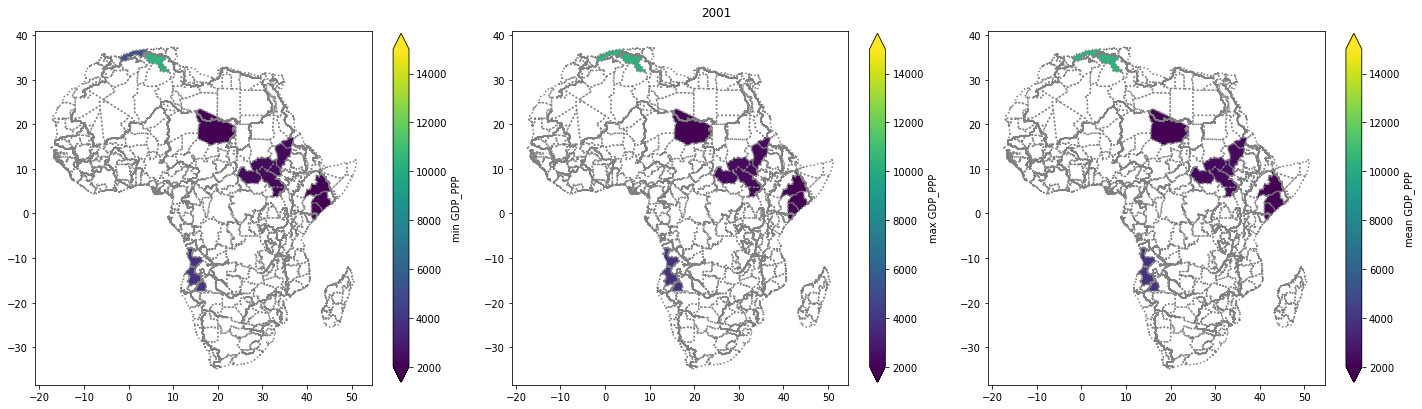

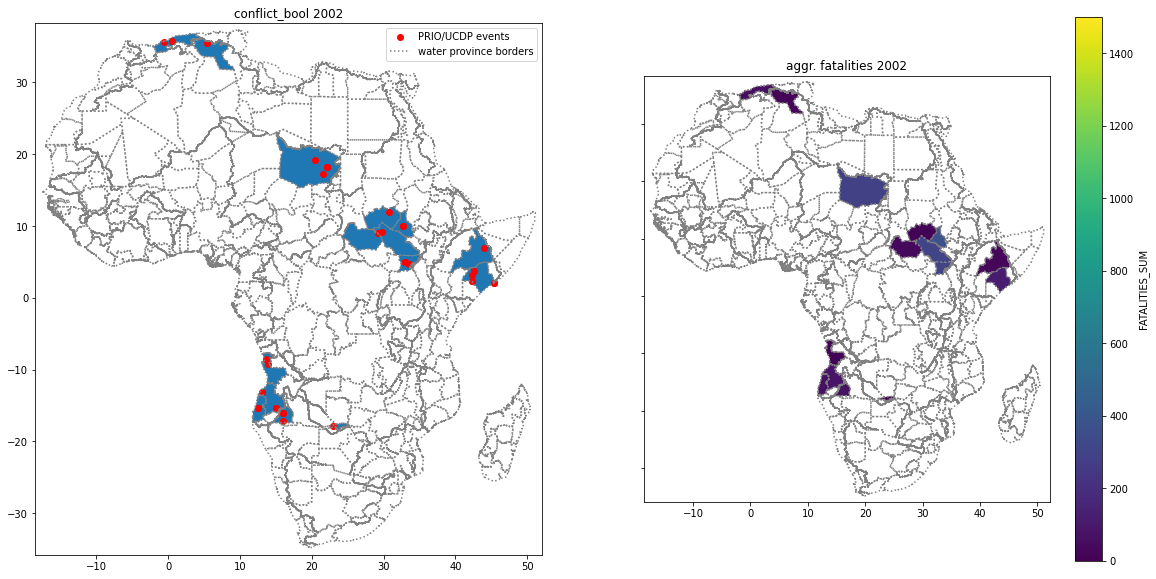

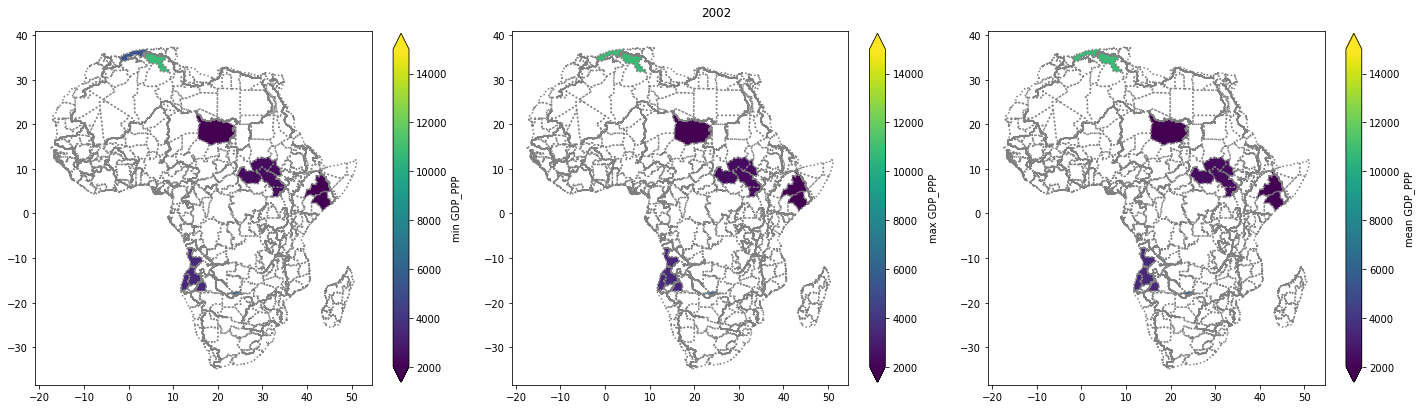

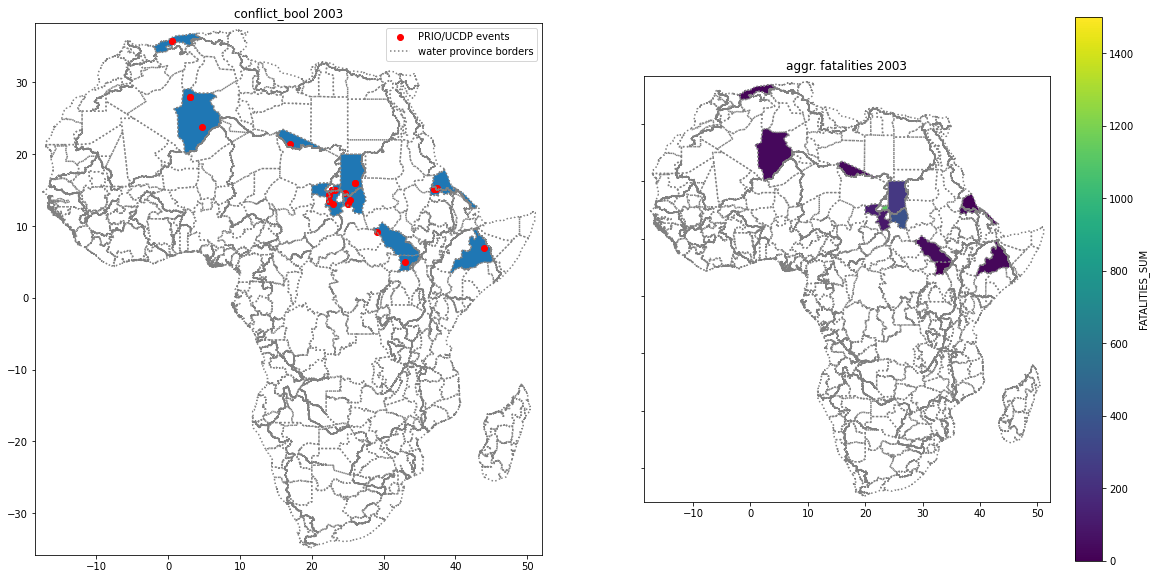

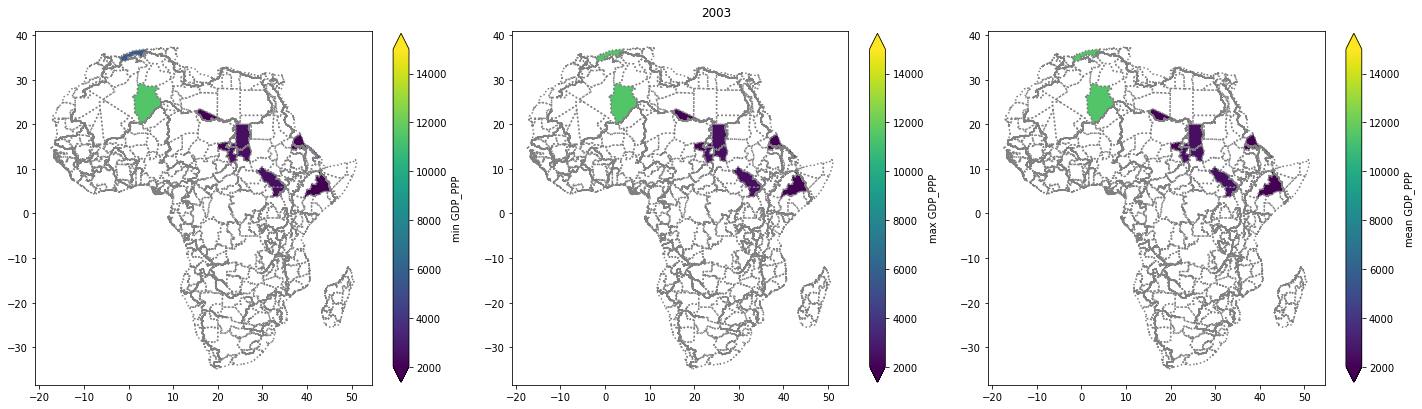

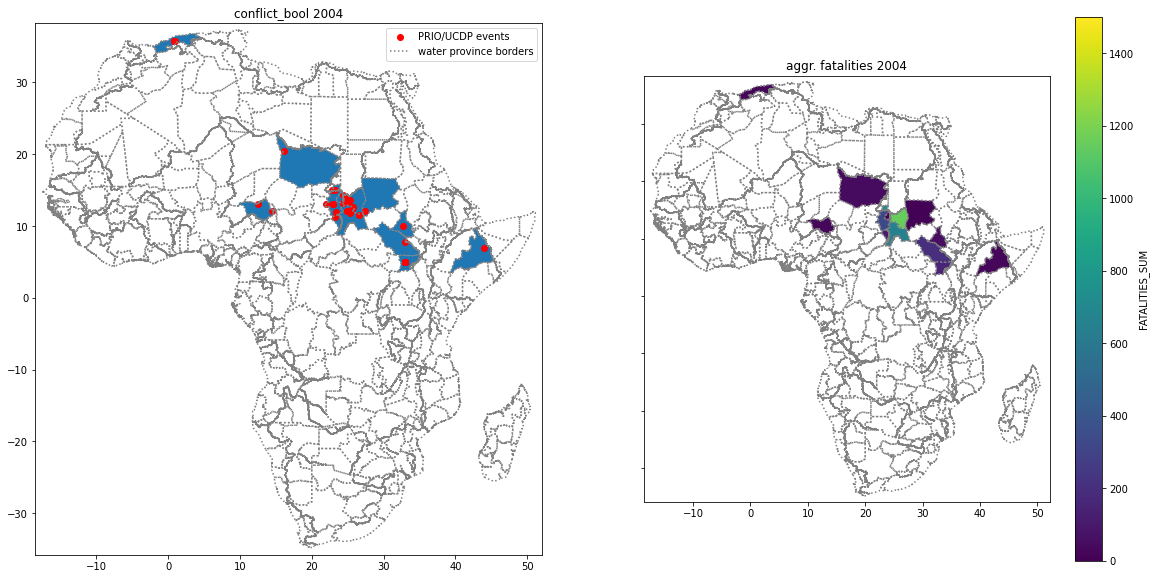

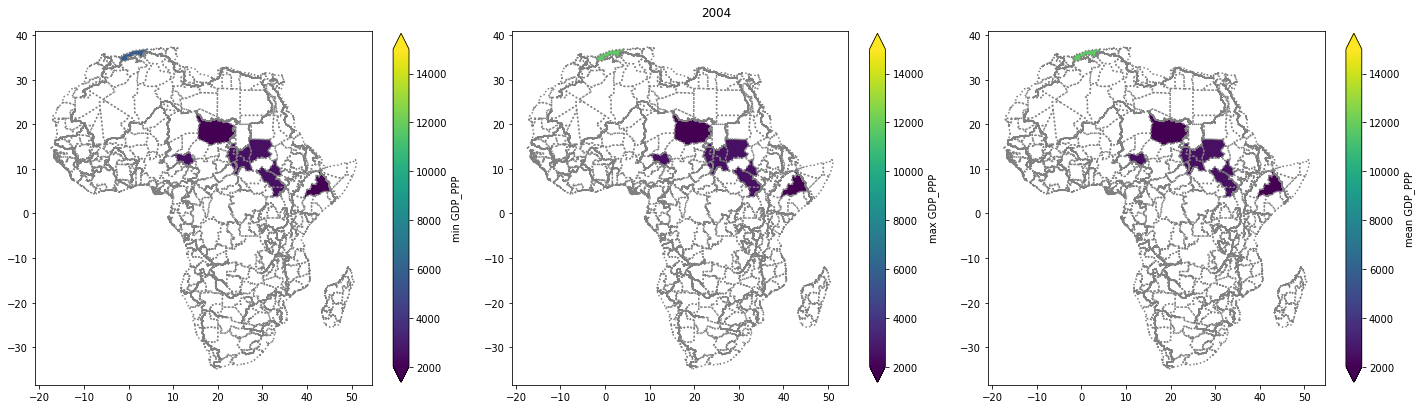

In [10]:
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):

    print('entering year {}'.format(sim_year) + os.linesep)
    
    temp_sel_year, data_merged, extent_waterProvinces_with_boolFatalities = conflict_in_year_bool(conflict_gdf,
                                                                                                  extent_gdf, 
                                                                                                  config, 
                                                                                                  sim_year, 
                                                                                                  out_dir, 
                                                                                                  showing_plots=True, 
                                                                                                  saving_plots=False)
    
#     conflict_gdf_perYear, 
#         extent_conflict_merged, 
#             fatalities_per_waterProvince, 
#                 extent_waterProvinces_with_boolFatalities = conflict_model.analysis.conflict_in_year_bool(conflict_gdf, 
#                                                                                                           extent_gdf, 
#                                                                                                           config,
#                                                                                                           sim_year,
#                                                                                                           out_dir, 
#                                                                                                           showing_plots=True, 
#                                                                                                           saving_plots=False)
    
    GDP_PPP_gdf = conflict_model.env_vars_nc.rasterstats_GDP_PPP(extent_waterProvinces_with_boolFatalities,
                                                                 extent_gdf,
                                                                 config,
                                                                 sim_year,
                                                                 out_dir,
                                                                 showing_plots=True,
                                                                 saving_plots=False)

In [11]:
extent_waterProvinces_with_boolFatalities.head()

,OBJECTID,MAJORBASIN,COUNTRY,REGION,watprov,watprovID,km2,Shape_Leng,Shape_Area,geometry,best_SUM,conflict_bool
0,66,"Africa, North Interior",Sudan,Gharb Darfur,"Sudan_Gharb Darfur_Africa, North Interior",81,9977.17,5.471240,0.834729,"POLYGON ((23.99872 15.70365, 24.01158 15.61981...",710,1
1,187,Lake Chad,Chad,Borkou-Ennedi-Tibesti,Chad_Borkou-Ennedi-Tibesti_Lake Chad,774,464325.00,43.070627,39.522299,"POLYGON ((21.79167 20.66702, 22.35708 20.37380...",46,1
2,197,Lake Chad,Nigeria,Borno,Nigeria_Borno_Lake Chad,784,98478.20,19.076060,8.133836,"POLYGON ((13.63796 13.71815, 13.70655 13.61841...",25,1
3,198,Lake Chad,Sudan,Gharb Darfur,Sudan_Gharb Darfur_Lake Chad,785,67317.20,15.274030,5.579098,"POLYGON ((24.08863 14.91250, 24.09432 14.89008...",329,1
4,199,Lake Chad,Sudan,Janub Darfur,Sudan_Janub Darfur_Lake Chad,786,19879.80,7.340367,1.632659,"POLYGON ((23.65358 9.40417, 23.66655 9.41820, ...",120,1


# Debugging

So the master dataframe with ALL conflicts reported looks like this...

In [12]:
conflict_gdf.head()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high,geometry
760,8202,2000,1,1,309,Sudan: Government,663,Government of Sudan - SPLM/A,112,625.0,...,2000-06-18,2000-06-21,430,0,0,0,430,430,430,POINT (32.70000 10.00000)
836,8723,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-01-16,2004-01-19,560,100,0,0,660,660,660,POINT (22.80000 15.00000)
839,8168,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-11-21,2004-11-23,30,0,7,0,37,37,37,POINT (24.90000 13.50000)
1324,33456,2000,1,1,409,Eritrea - Ethiopia,865,Government of Eritrea - Government of Ethiopia,98,531.0,...,2000-05-23,2000-05-25,24,0,0,0,24,24,24,POINT (39.38500 14.52194)
1326,34440,2000,1,1,409,Eritrea - Ethiopia,865,Government of Eritrea - Government of Ethiopia,98,531.0,...,2000-06-05,2000-06-06,700,0,0,0,700,700,700,POINT (36.65750 15.11000)


...and has in total that many entries:

In [13]:
len(conflict_gdf)

225

In the last year of the simulation period, a subset is created of all conflict entries which started in this year. It thus has the same columns as the master dataframe...

In [14]:
temp_sel_year.head()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high,geometry
836,8723,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-01-16,2004-01-19,560,100,0,0,660,660,660,POINT (22.80000 15.00000)
839,8168,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-11-21,2004-11-23,30,0,7,0,37,37,37,POINT (24.90000 13.50000)
4056,6802,2004,1,1,309,Sudan: Government,665,Government of Sudan - JEM,112,625.0,...,2004-06-09,2004-06-09,36,1,0,0,37,37,37,POINT (23.00000 13.00000)
26888,7851,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-02-16,2004-02-16,200,0,0,0,200,200,200,POINT (23.00000 13.00000)
58600,71589,2004,1,1,329,Ethiopia: Ogaden,719,Government of Ethiopia - ONLF,97,530.0,...,2004-01-01,2004-12-31,0,0,0,25,25,25,0,POINT (44.00000 7.00000)


...but of course less entries, namely only that many entries:

In [15]:
len(temp_sel_year)

38

This sub-set dataframe is then merged with the dataframe containing the geometry of the water provinces. Each conflict entry in the sub-set dataframe is assigned the water province (plus water province data) where the conflict took place.

In [16]:
data_merged.head()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,index_right,OBJECTID,MAJORBASIN,COUNTRY,REGION,watprov,watprovID,km2,Shape_Leng,Shape_Area
836,8723,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,65,66,"Africa, North Interior",Sudan,Gharb Darfur,"Sudan_Gharb Darfur_Africa, North Interior",81,9977.17,5.471240,0.834729
59451,8120,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,65,66,"Africa, North Interior",Sudan,Gharb Darfur,"Sudan_Gharb Darfur_Africa, North Interior",81,9977.17,5.471240,0.834729
839,8168,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,296,297,Nile,Sudan,Shamal Darfur,Sudan_Shamal Darfur_Nile,1018,84862.90,15.987983,7.043560
59021,9231,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,296,297,Nile,Sudan,Shamal Darfur,Sudan_Shamal Darfur_Nile,1018,84862.90,15.987983,7.043560
59354,6928,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,296,297,Nile,Sudan,Shamal Darfur,Sudan_Shamal Darfur_Nile,1018,84862.90,15.987983,7.043560


Logically, this merged dataframe has as many entries as the sub-set dataframe but more columns, i.e. those added from the extent dataframe:

In [17]:
len(data_merged)

38

Per water province the number of fatalities is summed and added to a new column. Also, a boolean value of 1 (i.e. True) is assigned to each water province, indicating that one or more conflict took place in this province. The structure of the dataframe (besides the two added columns) is coming from the geometry/extent dataframe of the water provinces and NOT from the dataframe containing the conflict data.

In [18]:
extent_waterProvinces_with_boolFatalities.head()

,OBJECTID,MAJORBASIN,COUNTRY,REGION,watprov,watprovID,km2,Shape_Leng,Shape_Area,geometry,best_SUM,conflict_bool
0,66,"Africa, North Interior",Sudan,Gharb Darfur,"Sudan_Gharb Darfur_Africa, North Interior",81,9977.17,5.471240,0.834729,"POLYGON ((23.99872 15.70365, 24.01158 15.61981...",710,1
1,187,Lake Chad,Chad,Borkou-Ennedi-Tibesti,Chad_Borkou-Ennedi-Tibesti_Lake Chad,774,464325.00,43.070627,39.522299,"POLYGON ((21.79167 20.66702, 22.35708 20.37380...",46,1
2,197,Lake Chad,Nigeria,Borno,Nigeria_Borno_Lake Chad,784,98478.20,19.076060,8.133836,"POLYGON ((13.63796 13.71815, 13.70655 13.61841...",25,1
3,198,Lake Chad,Sudan,Gharb Darfur,Sudan_Gharb Darfur_Lake Chad,785,67317.20,15.274030,5.579098,"POLYGON ((24.08863 14.91250, 24.09432 14.89008...",329,1
4,199,Lake Chad,Sudan,Janub Darfur,Sudan_Janub Darfur_Lake Chad,786,19879.80,7.340367,1.632659,"POLYGON ((23.65358 9.40417, 23.66655 9.41820, ...",120,1


Since one or more conflicts can occur in one water province (which is very likely), only a few water provinces are found in this dataframe. This is also because the code currently drops all water provinces which have not seen conflict in this year.

In [19]:
len(extent_waterProvinces_with_boolFatalities)

14

As a result, the zonal statistics are only stored for those water provinces.

NOTE: if you use the geometry/extent dataframe instead as argument, zonal statistics are computed for all water provinces, but then the columns containing (boolean) fatalities are lost.

In [20]:
GDP_PPP_gdf.head()

,OBJECTID,MAJORBASIN,COUNTRY,REGION,watprov,watprovID,km2,Shape_Leng,Shape_Area,geometry,best_SUM,conflict_bool,zonal_stats_min,zonal_stats_max,zonal_stats_mean
0,66,"Africa, North Interior",Sudan,Gharb Darfur,"Sudan_Gharb Darfur_Africa, North Interior",81,9977.17,5.471240,0.834729,"POLYGON ((23.99872 15.70365, 24.01158 15.61981...",710,1,2527.752686,2527.752686,2527.752686
1,187,Lake Chad,Chad,Borkou-Ennedi-Tibesti,Chad_Borkou-Ennedi-Tibesti_Lake Chad,774,464325.00,43.070627,39.522299,"POLYGON ((21.79167 20.66702, 22.35708 20.37380...",46,1,765.075989,1584.598877,1584.454848
2,197,Lake Chad,Nigeria,Borno,Nigeria_Borno_Lake Chad,784,98478.20,19.076060,8.133836,"POLYGON ((13.63796 13.71815, 13.70655 13.61841...",25,1,2510.436523,2510.436523,2510.436523
3,198,Lake Chad,Sudan,Gharb Darfur,Sudan_Gharb Darfur_Lake Chad,785,67317.20,15.274030,5.579098,"POLYGON ((24.08863 14.91250, 24.09432 14.89008...",329,1,2527.752686,2527.752686,2527.752686
4,199,Lake Chad,Sudan,Janub Darfur,Sudan_Janub Darfur_Lake Chad,786,19879.80,7.340367,1.632659,"POLYGON ((23.65358 9.40417, 23.66655 9.41820, ...",120,1,2527.752686,2527.752686,2527.752686


In [21]:
len(GDP_PPP_gdf)

14